# 0. Library

In [ ]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import time
import pickle  # To load potential preprocessing objects if needed, though data is CSV

# --- Sklearn ---
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve, auc,
                             accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, brier_score_loss, log_loss, classification_report)
from sklearn.pipeline import Pipeline as SklearnPipeline # To distinguish from imblearn Pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.base import clone
from sklearn.feature_selection import VarianceThreshold

# --- Imbalanced Learn ---
from imblearn.pipeline import Pipeline as ImblearnPipeline
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE # Offering alternatives

# --- Model Specific Libraries ---
import xgboost as xgb
import lightgbm as lgb

# --- WOE/Scorecard Library ---
import scorecardpy as sc # For LR+WOE variant

# --- Bayesian Optimization ---
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt.callbacks import CheckpointSaver

# 1. Utility Function + Configuration

In [2]:
# --- Helper Functions ---
def calculate_ks(y_true, y_prob):
    """Calculates the Kolmogorov-Smirnov (KS) statistic."""
    df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df = df.sort_values(by='y_prob', ascending=False)
    df['cumulative_true'] = df['y_true'].cumsum() / df['y_true'].sum()
    df['cumulative_false'] = (1 - df['y_true']).cumsum() / (1 - df['y_true']).sum()
    ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
    return ks

def find_optimal_threshold_j_statistic(y_true, y_prob_oof):
    """Finds the optimal threshold maximizing Youden's J statistic (Sensitivity + Specificity - 1)."""
    fpr, tpr, thresholds = roc_curve(y_true, y_prob_oof)
    j_statistic = tpr - fpr
    optimal_idx = np.argmax(j_statistic)
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal threshold based on Youden's J-Statistic (OOF): {optimal_threshold:.4f}")
    return optimal_threshold

def evaluate_model(y_true, y_pred_proba, y_pred_binary, model_name="Model"):
    """Calculates and prints standard classification metrics."""
    auc_roc = roc_auc_score(y_true, y_pred_proba)
    gini = 2 * auc_roc - 1
    ks = calculate_ks(y_true, y_pred_proba)
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    brier = brier_score_loss(y_true, y_pred_proba)
    logloss = log_loss(y_true, y_pred_proba)
    cm = confusion_matrix(y_true, y_pred_binary)

    print(f"\n--- Evaluation Metrics for {model_name} ---")
    print(f"AUC ROC:        {auc_roc:.4f}")
    print(f"Gini Coefficient: {gini:.4f}")
    print(f"KS Statistic:   {ks:.4f}")
    print(f"Accuracy:       {accuracy:.4f}")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall (TPR):   {recall:.4f}")
    print(f"F1-Score:       {f1:.4f}")
    print(f"Brier Score:    {brier:.4f}")
    print(f"Log Loss:       {logloss:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    # print("\nClassification Report:")
    # print(classification_report(y_true, y_pred_binary))

    results = {
        'Model': model_name,
        'AUC': auc_roc,
        'Gini': gini,
        'KS': ks,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Brier': brier,
        'LogLoss': logloss
    }
    return results

def plot_roc_curve(y_true, y_prob, model_name):
    """Plots the ROC curve."""
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_roc = roc_auc_score(y_true, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_roc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

def get_feature_importance(model, feature_names, top_n=50):
    """Extracts and displays feature importances."""
    print(f"\n--- Top {top_n} Feature Importances ---")
    try:
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            # For linear models, use absolute coefficient values
            importances = np.abs(model.coef_[0]) # Assuming binary classification coef_[0]
        else:
            print("Model does not have standard feature_importances_ or coef_ attribute.")
            return None

        feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

        # Check if importance sum is close to 1 (typical for tree models)
        print(f"Sum of importances: {feature_importance_df['importance'].sum():.4f}")

        display(feature_importance_df.head(top_n))
        return feature_importance_df

    except Exception as e:
        print(f"Could not get feature importances: {e}")
        return None


In [3]:
# --- Configuration ---
DATA_PATH = '../data/processed/'
SEED = 42
N_SPLITS = 5 # Number of folds for Cross-Validation
SMOTE_STRATEGY = 0.25 # Ratio of minority samples to majority after resampling
# Choose SMOTE variant: SMOTE, ADASYN, BorderlineSMOTE
SMOTE_VARIANT = BorderlineSMOTE(sampling_strategy=SMOTE_STRATEGY, random_state=SEED)

# 2. Data Loading and Preprocessing

In [4]:
# --- Load Data ---
print("Loading preprocessed data...")
try:
    train_df = pd.read_csv(DATA_PATH + 'train_final.csv')
    test_df = pd.read_csv(DATA_PATH + 'test_final.csv')
    print("Data loaded successfully.")
    print(f"Train shape: {train_df.shape}")
    print(f"Test shape: {test_df.shape}")
except FileNotFoundError as e:
    print(f"Error: {e}. Make sure 'train_final.csv' and 'test_final.csv' are in {DATA_PATH}")
    # Exit or raise error if files not found
    raise FileNotFoundError(f"Data files not found in {DATA_PATH}")
except Exception as e:
    print(f"An error occurred while loading data: {e}")
    raise # Exit or raise error if any other issue occurs

Loading preprocessed data...
Data loaded successfully.
Train shape: (246005, 775)
Test shape: (61502, 775)


In [5]:
# --- Prepare Data for Modeling ---
TARGET = 'TARGET'
ID_COL = 'SK_ID_CURR' # Assuming ID column might still be present

# Align columns - crucial if feature engineering created different cols slightly
train_labels = train_df[TARGET]
test_labels = test_df[TARGET]

# Drop Target and potentially ID from features
if ID_COL in train_df.columns:
    train_ids = train_df[ID_COL]
    test_ids = test_df[ID_COL]
    train_df = train_df.drop(columns=[TARGET, ID_COL])
    test_df = test_df.drop(columns=[TARGET, ID_COL])
else:
    train_df = train_df.drop(columns=[TARGET])
    test_df = test_df.drop(columns=[TARGET])

# Ensure columns are in the same order
common_cols = list(train_df.columns.intersection(test_df.columns))
X_train = train_df[common_cols].copy()
X_test = test_df[common_cols].copy()
y_train = train_labels.copy()
y_test = test_labels.copy()

# Capture feature names for later use
feature_names = X_train.columns.tolist()

print(f"Prepared X_train shape: {X_train.shape}")
print(f"Prepared X_test shape: {X_test.shape}")
print(f"Number of features: {len(feature_names)}")

# --- Cross-Validation Setup ---
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

# --- Results Storage ---
baseline_results = []
tuned_results = []
model_objects = {} # To store best tuned models for stacking

Prepared X_train shape: (246005, 773)
Prepared X_test shape: (61502, 773)
Number of features: 773


## 2.1 Featue Selection

- Step:
    + Remove Low Variance Features
    + Remove Correlated Features

In [ ]:
def feature_selection(X, y, threshold_variance=0.01, threshold_correlation=0.85):
    """Feature selection based on variance and correlation."""
    # Variance Threshold
    from sklearn.feature_selection import VarianceThreshold
    selector = VarianceThreshold(threshold=threshold_variance)
    X_var = selector.fit_transform(X)
    selected_features_var = X.columns[selector.get_support()]

    # Correlation Matrix
    corr_matrix = X.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold_correlation)]
    
    # Drop highly correlated features
    X_corr = X.drop(columns=to_drop)
    
    # Final selected features
    selected_features_final = list(set(selected_features_var) - set(to_drop))
    
    print(f"Selected {len(selected_features_final)} features after variance and correlation filtering.")
    
    return X[selected_features_final], selected_features_final
    

# 3. Model 1: Logistic Regression + WOE

In [6]:
# # --- Model 1: Logistic Regression + WOE (Special Handling) ---
# print("\n" + "="*60)
# print("Model 1: Logistic Regression + WOE")
# print("="*60)

# # Step 1.1: WOE Binning (Fit ONLY on Training Data)
# # Filter features with IV > 0.02 (common practice)
# # Handle potential infinite values after Response Encoding if needed before WOE
# X_train_woe_input = X_train.replace([np.inf, -np.inf], np.nan) # Replace inf
# X_test_woe_input = X_test.replace([np.inf, -np.inf], np.nan)

# # Impute remaining NaNs before WOE binning (median for numeric)
# # Consider if specific imputation was done before saving CSVs
# num_cols = X_train_woe_input.select_dtypes(include=np.number).columns
# for col in num_cols:
#      median_val = X_train_woe_input[col].median()
#      X_train_woe_input[col] = X_train_woe_input[col].fillna(median_val)
#      X_test_woe_input[col] = X_test_woe_input[col].fillna(median_val) # Use train median for test

# print("Starting WOE binning (fit on train data)...")
# bins = sc.woebin(X_train_woe_input.join(y_train), y=TARGET, positive=TARGET+'|1', method='chimerge', bin_num_limit=10)
# # sc.woebin_plot(bins) # Optional: Visualize bins

# # Filter bins by IV > 0.02
# significant_bins = {k: v for k, v in bins.items() if v['total_iv'].iloc[0] > 0.02}
# woe_features = list(significant_bins.keys())
# print(f"Selected {len(woe_features)} features based on IV > 0.02 for WOE LR.")

# if not woe_features:
#      print("Warning: No features found with IV > 0.02. WOE LR cannot proceed.")
# else:
#     # Step 1.2: Apply WOE Transformation
#     print("Applying WOE transformation...")
#     X_train_woe = sc.woebin_ply(X_train_woe_input[woe_features], significant_bins)
#     X_test_woe = sc.woebin_ply(X_test_woe_input[woe_features], significant_bins)
#     woe_feature_names = X_train_woe.columns.tolist() # Capture WOE feature names

#     # Step 1.3: Baseline LR + WOE (No SMOTE/Scaling)
#     print("\n--- Baseline LR + WOE Training ---")
#     lr_woe_base = LogisticRegression(random_state=SEED, solver='liblinear', class_weight='balanced') # Balanced weights as proxy for SMOTE
#     lr_woe_base.fit(X_train_woe, y_train)

#     y_pred_proba_test_base = lr_woe_base.predict_proba(X_test_woe)[:, 1]
#     # Use 0.5 threshold for baseline report
#     y_pred_bin_test_base = (y_pred_proba_test_base >= 0.5).astype(int)
#     baseline_results.append(evaluate_model(y_test, y_pred_proba_test_base, y_pred_bin_test_base, "LR + WOE (Baseline)"))
#     plot_roc_curve(y_test, y_pred_proba_test_base, "LR + WOE (Baseline)")
#     get_feature_importance(lr_woe_base, woe_feature_names)

#     # Step 1.4: Hyperparameter Tuning (Tuning C)
#     print("\n--- Tuned LR + WOE Training ---")
#     param_grid_lr_woe = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
#     # Note: No pipeline needed here, tuning directly on WOE data
#     grid_search_lr_woe = GridSearchCV(LogisticRegression(random_state=SEED, solver='liblinear', class_weight='balanced'),
#                                       param_grid_lr_woe, cv=cv, scoring='roc_auc', n_jobs=-1, refit=True)
#     grid_search_lr_woe.fit(X_train_woe, y_train)
#     best_lr_woe = grid_search_lr_woe.best_estimator_
#     print(f"Best Params (LR + WOE): {grid_search_lr_woe.best_params_}")

#     # Step 1.5: Optimal Threshold and Evaluation
#     # Get OOF predictions on WOE-transformed training data
#     y_prob_oof_lr_woe = cross_val_predict(best_lr_woe, X_train_woe, y_train, cv=cv, method='predict_proba')[:, 1]
#     optimal_threshold_lr_woe = find_optimal_threshold_j_statistic(y_train, y_prob_oof_lr_woe)

#     y_pred_proba_test_tuned = best_lr_woe.predict_proba(X_test_woe)[:, 1]
#     y_pred_bin_test_tuned = (y_pred_proba_test_tuned >= optimal_threshold_lr_woe).astype(int)
#     tuned_results.append(evaluate_model(y_test, y_pred_proba_test_tuned, y_pred_bin_test_tuned, "LR + WOE (Tuned)"))
#     plot_roc_curve(y_test, y_pred_proba_test_tuned, "LR + WOE (Tuned)")
#     get_feature_importance(best_lr_woe, woe_feature_names)
#     model_objects['LR_WOE'] = best_lr_woe # Store the best model

# 4. Model 2: Logistic Regression with SGD


Model 2: SGDClassifier with Multi-Metric Bayesian Optimization

--- Baseline SGDClassifier Training ---

--- Evaluation Metrics for SGDClassifier (Baseline) ---
AUC ROC:        0.7101
Gini Coefficient: 0.4202
KS Statistic:   0.3157
Accuracy:       0.6908
Precision:      0.1504
Recall (TPR):   0.6085
F1-Score:       0.2411
Brier Score:    0.2096
Log Loss:       0.6361

Confusion Matrix:
[[39467 17070]
 [ 1944  3021]]


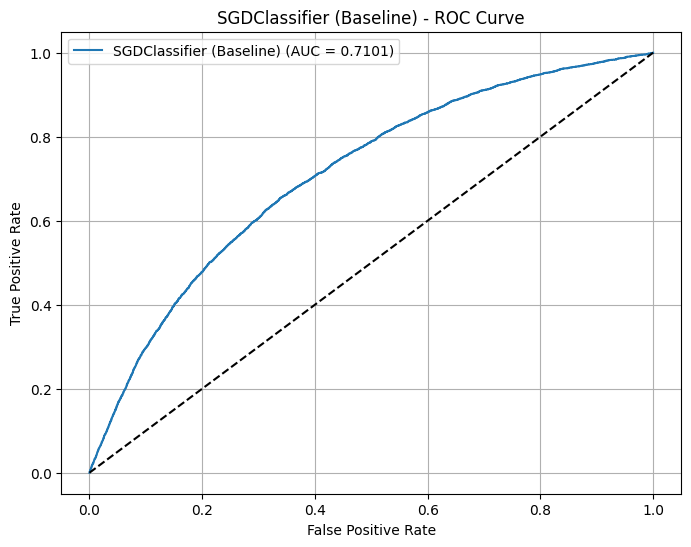


--- Multi-Metric Bayesian Optimization for SGDClassifier ---
Starting Multi-Metric Bayesian optimization with 50 iterations...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, tota

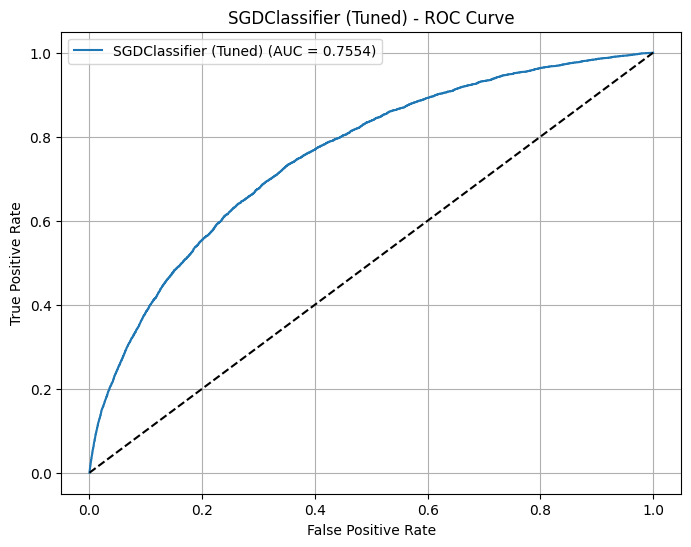


--- Top 50 Feature Importances ---
Sum of importances: 2.2411


,feature,importance
129,WEIGHTED_EXT_SOURCE,0.060867
269,TARGET_MEAN_AGG_OCCUPATION_TYPE_ORGANIZATION_TYPE,0.059885
125,EXT_SOURCE_MEAN,0.057389
29,EXT_SOURCE_3,0.054829
128,EXT_SOURCE_MIN,0.045039
127,EXT_SOURCE_MAX,0.041414
28,EXT_SOURCE_2,0.034169
103,CREDIT_GOODS_RATIO,0.030708
245,TARGET_MEAN_AGG_NAME_EDUCATION_TYPE_NAME_INCOM...,0.029576
27,EXT_SOURCE_1,0.029019


In [ ]:
# --- Model 2: SGDClassifier with Multi-Metric Bayesian Optimization ---
print("\n" + "="*60)
print("Model 2: SGDClassifier with Multi-Metric Bayesian Optimization")
print("="*60)

# Step 2.1: Baseline Pipeline
print("\n--- Baseline SGDClassifier Training ---")
sgd_base_pipeline = ImblearnPipeline([
    #('smote', SMOTE_VARIANT),
    ('scaler', StandardScaler()),
    ('model', SGDClassifier(loss='log_loss', penalty='l2', random_state=SEED, 
                            class_weight='balanced', n_jobs=-1, tol=1e-3))
])

sgd_base_pipeline.fit(X_train, y_train)
y_pred_proba_test_base = sgd_base_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_base = (y_pred_proba_test_base >= 0.5).astype(int)
baseline_results.append(evaluate_model(y_test, y_pred_proba_test_base, y_pred_bin_test_base, "SGDClassifier (Baseline)"))
plot_roc_curve(y_test, y_pred_proba_test_base, "SGDClassifier (Baseline)")

# Step 2.2: Multi-Metric Bayesian Hyperparameter Optimization
print("\n--- Multi-Metric Bayesian Optimization for SGDClassifier ---")

# Define parameter space for Bayesian optimization
param_space_sgd = {
    'model__alpha': Real(1e-5, 1.0, prior='log-uniform'),
    'model__max_iter': Integer(500, 2000),
    'model__loss': Categorical(['log_loss', 'modified_huber']),
    'model__penalty': Categorical(['l2', 'elasticnet']),
    'model__class_weight': Categorical(['balanced', None]),
    'model__learning_rate': Categorical(['optimal', 'constant', 'invscaling']),
    'model__eta0': Real(0.001, 0.5, prior='log-uniform')
}

# Define scoring metrics and weights
scoring = {
    'f1': 'f1',
    'f1_balanced': 'f1_weighted',  # Weighted by class frequency
    'recall': 'recall'
}

# Define weights for each metric
weights = {
    'f1': 0.2,
    'f1_balanced': 0.5,
    'recall': 0.3
}

# Create a custom metric function for optimization
def custom_weighted_score(results):
    """Calculate a weighted score across multiple metrics"""
    total_score = 0
    for metric, weight in weights.items():
        metric_key = f'mean_test_{metric}'
        if metric_key in results.keys():
            total_score += results[metric_key][-1] * weight
    return total_score

# Create a checkpoint saver to track progress
checkpoint_path = "sgd_bayes_opt_checkpoint.pkl"
checkpoint_saver = CheckpointSaver(checkpoint_path, compress=9)

# Number of parameter settings that are sampled
n_iter_search = 50

# Set up BayesSearchCV 
bayes_search = BayesSearchCV(
    sgd_base_pipeline,
    param_space_sgd,
    n_iter=n_iter_search,
    cv=cv,
    scoring=scoring,
    refit='f1_balanced',  # Use f1_balanced as primary metric for final model
    n_jobs=-1,
    random_state=SEED,
    verbose=10
)

# Run optimization
print(f"Starting Multi-Metric Bayesian optimization with {n_iter_search} iterations...")
start_time = time.time()

# Fit with checkpoint saver callback
bayes_search.fit(X_train, y_train, callback=[checkpoint_saver])

end_time = time.time()
print(f"Bayesian optimization completed in {(end_time - start_time)/60:.2f} minutes")

# Get best model and parameters
best_sgd_pipeline = bayes_search.best_estimator_
print(f"Best Params (SGDClassifier): {bayes_search.best_params_}")
print(f"Best CV Scores:")
for metric in scoring.keys():
    print(f"  {metric}: {bayes_search.cv_results_['mean_test_' + metric][bayes_search.best_index_]:.4f}")

# Calculate weighted scores for all results
weighted_scores = []
for i in range(len(bayes_search.cv_results_['mean_test_f1'])):
    result = {f'mean_test_{metric}': bayes_search.cv_results_[f'mean_test_{metric}'][i] for metric in scoring.keys()}
    weighted_score = sum(result[f'mean_test_{metric}'] * weight for metric, weight in weights.items())
    weighted_scores.append(weighted_score)

# Find the index of the best weighted score
best_weighted_index = np.argmax(weighted_scores)
best_weighted_params = {param_name: bayes_search.cv_results_['param_'+param_name][best_weighted_index] 
                        for param_name in param_space_sgd.keys()}

print("\nBest Parameters based on weighted score:")
print(best_weighted_params)
print("Weighted Score Metrics:")
for metric in scoring.keys():
    print(f"  {metric}: {bayes_search.cv_results_['mean_test_' + metric][best_weighted_index]:.4f}")
print(f"  Weighted Score: {weighted_scores[best_weighted_index]:.4f}")

# If the best weighted model is different, create it
if best_weighted_index != bayes_search.best_index_:
    print("\nBuilding model with best weighted parameters...")
    weighted_best_pipeline = clone(sgd_base_pipeline)
    weighted_best_pipeline.set_params(**{param: value for param, value in best_weighted_params.items()})
    weighted_best_pipeline.fit(X_train, y_train)
    best_pipeline_to_use = weighted_best_pipeline
    print("Using model with best weighted parameters for evaluation")
else:
    best_pipeline_to_use = best_sgd_pipeline
    print("Best weighted parameters match refit model parameters")

# Step 2.3: Optimal Threshold and Evaluation
y_prob_oof_sgd = cross_val_predict(best_pipeline_to_use, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
optimal_threshold_sgd = find_optimal_threshold_j_statistic(y_train, y_prob_oof_sgd)

y_pred_proba_test_tuned = best_pipeline_to_use.predict_proba(X_test)[:, 1]
y_pred_bin_test_tuned = (y_pred_proba_test_tuned >= optimal_threshold_sgd).astype(int)
tuned_results.append(evaluate_model(y_test, y_pred_proba_test_tuned, y_pred_bin_test_tuned, "SGDClassifier (Tuned)"))
plot_roc_curve(y_test, y_pred_proba_test_tuned, "SGDClassifier (Tuned)")

# Feature importance via coefficients
final_sgd_model = best_pipeline_to_use.named_steps['model']
if hasattr(final_sgd_model, 'coef_'):
     get_feature_importance(final_sgd_model, feature_names)

model_objects['SGD'] = best_pipeline_to_use # Store the best pipeline

# 5. Model 3: XGBoost


Model 3: XGBoost

--- Baseline XGBoost Training ---


c:\Users\ORLab\main_source\CreditRiskProject\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:08:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Evaluation Metrics for XGBoost (Baseline) ---
AUC ROC:        0.7602
Gini Coefficient: 0.5204
KS Statistic:   0.3899
Accuracy:       0.9189
Precision:      0.4790
Recall (TPR):   0.0506
F1-Score:       0.0915
Brier Score:    0.0680
Log Loss:       0.2471

Confusion Matrix:
[[56264   273]
 [ 4714   251]]


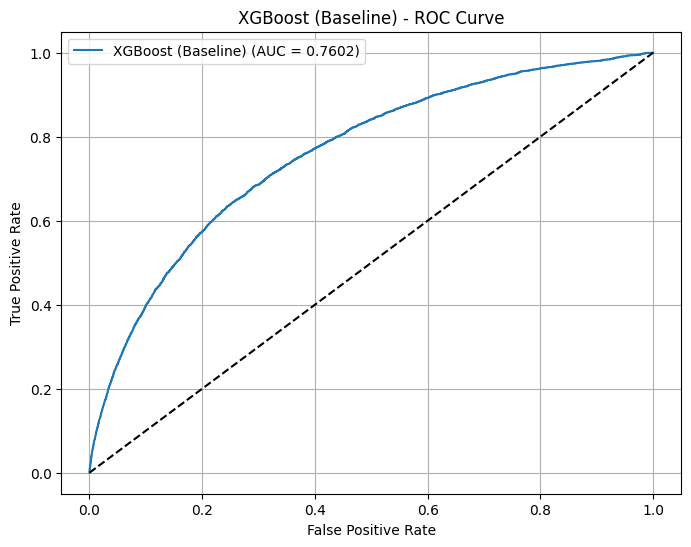


--- Top 50 Feature Importances ---
Sum of importances: 1.0000


,feature,importance
132,APARTMENTS_SUM_MODE,0.102921
536,B_BB_STATUS_ENCODED_LAST_YEAR_REST_MAX_OVERALL,0.078883
18,REGION_RATING_CLIENT,0.042187
307,HOUSETYPE_MODE_RESPONSE_1,0.041358
309,EMERGENCYSTATE_MODE_RESPONSE_1,0.033238
296,FLAG_OWN_CAR_RESPONSE_1,0.026854
300,NAME_EDUCATION_TYPE_RESPONSE_1,0.024930
15,FLAG_PHONE,0.021179
301,NAME_FAMILY_STATUS_RESPONSE_1,0.021039
125,EXT_SOURCE_MEAN,0.019145



--- Tuned XGBoost Training (GridSearch - may take time) ---
Fitting 5 folds for each of 256 candidates, totalling 1280 fits


c:\Users\ORLab\main_source\CreditRiskProject\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


MemoryError: Unable to allocate 1.08 GiB for an array with shape (734, 196804) and data type float64

In [8]:
# --- Model 3: XGBoost ---
print("\n" + "="*60)
print("Model 3: XGBoost")
print("="*60)

# Step 3.1: Baseline Pipeline
print("\n--- Baseline XGBoost Training ---")
xgb_base_pipeline = ImblearnPipeline([
    ('smote', SMOTE_VARIANT),
    ('scaler', StandardScaler()),
    ('model', xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', use_label_encoder=False, random_state=SEED, n_jobs=-1))
])
xgb_base_pipeline.fit(X_train, y_train)
y_pred_proba_test_base = xgb_base_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_base = (y_pred_proba_test_base >= 0.5).astype(int)
baseline_results.append(evaluate_model(y_test, y_pred_proba_test_base, y_pred_bin_test_base, "XGBoost (Baseline)"))
plot_roc_curve(y_test, y_pred_proba_test_base, "XGBoost (Baseline)")
get_feature_importance(xgb_base_pipeline.named_steps['model'], feature_names)

# Step 3.2: Hyperparameter Tuning
# WARNING: GridSearchCV for XGBoost with SMOTE can be VERY slow. Consider RandomizedSearchCV or fewer parameter combinations.
print("\n--- Tuned XGBoost Training (GridSearch - may take time) ---")
param_grid_xgb = {
    'model__n_estimators': [100, 300], # Number of boosting rounds
    'model__max_depth': [3, 5],        # Maximum depth of a tree
    'model__learning_rate': [0.1, 0.05], # Step size shrinkage
    'model__subsample': [0.7, 1.0],    # Fraction of samples used for fitting the trees
    'model__colsample_bytree': [0.7, 1.0], # Fraction of features used for fitting the trees
    'model__gamma': [0, 0.1],         # Minimum loss reduction required to make a further partition
    'model__reg_alpha': [0, 0.1],      # L1 regularization
    'model__reg_lambda': [1, 0.1],     # L2 regularization
}
grid_search_xgb = GridSearchCV(xgb_base_pipeline, param_grid_xgb, cv=cv, scoring='roc_auc', n_jobs=-1, refit=True, verbose=1) # Add verbose
start_tune_time = time.time()
grid_search_xgb.fit(X_train, y_train)
end_tune_time = time.time()
print(f"XGBoost Tuning Time: {(end_tune_time - start_tune_time)/60:.2f} minutes")

best_xgb_pipeline = grid_search_xgb.best_estimator_
print(f"Best Params (XGBoost): {grid_search_xgb.best_params_}")

# Step 3.3: Optimal Threshold and Evaluation
y_prob_oof_xgb = cross_val_predict(best_xgb_pipeline, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
optimal_threshold_xgb = find_optimal_threshold_j_statistic(y_train, y_prob_oof_xgb)

y_pred_proba_test_tuned = best_xgb_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_tuned = (y_pred_proba_test_tuned >= optimal_threshold_xgb).astype(int)
tuned_results.append(evaluate_model(y_test, y_pred_proba_test_tuned, y_pred_bin_test_tuned, "XGBoost (Tuned)"))
plot_roc_curve(y_test, y_pred_proba_test_tuned, "XGBoost (Tuned)")
get_feature_importance(best_xgb_pipeline.named_steps['model'], feature_names)
model_objects['XGB'] = best_xgb_pipeline # Store the best pipeline

# 6. Model 4: LightGBM

In [ ]:
# --- Model 4: LightGBM ---
print("\n" + "="*60)
print("Model 4: LightGBM")
print("="*60)

# Step 4.1: Baseline Pipeline
print("\n--- Baseline LightGBM Training ---")
lgb_base_pipeline = ImblearnPipeline([
    ('smote', SMOTE_VARIANT),
    ('scaler', StandardScaler()),
    ('model', lgb.LGBMClassifier(objective='binary', metric='auc', random_state=SEED, n_jobs=-1))
])
lgb_base_pipeline.fit(X_train, y_train)
y_pred_proba_test_base = lgb_base_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_base = (y_pred_proba_test_base >= 0.5).astype(int)
baseline_results.append(evaluate_model(y_test, y_pred_proba_test_base, y_pred_bin_test_base, "LightGBM (Baseline)"))
plot_roc_curve(y_test, y_pred_proba_test_base, "LightGBM (Baseline)")
get_feature_importance(lgb_base_pipeline.named_steps['model'], feature_names)

# Step 4.2: Hyperparameter Tuning
# WARNING: Similar to XGBoost, can be slow. RandomizedSearch is often preferred for LGBM.
print("\n--- Tuned LightGBM Training (GridSearch - may take time) ---")
param_grid_lgb = {
    'model__n_estimators': [100, 300],
    'model__max_depth': [3, 5, -1], # -1 means no limit
    'model__learning_rate': [0.1, 0.05],
    'model__num_leaves': [31, 50], # Default 31
    'model__subsample': [0.7, 1.0],
    'model__colsample_bytree': [0.7, 1.0],
    'model__reg_alpha': [0, 0.1],
    'model__reg_lambda': [0, 0.1]
}
grid_search_lgb = GridSearchCV(lgb_base_pipeline, param_grid_lgb, cv=cv, scoring='roc_auc', n_jobs=-1, refit=True, verbose=1)
start_tune_time = time.time()
grid_search_lgb.fit(X_train, y_train)
end_tune_time = time.time()
print(f"LightGBM Tuning Time: {(end_tune_time - start_tune_time)/60:.2f} minutes")

best_lgb_pipeline = grid_search_lgb.best_estimator_
print(f"Best Params (LightGBM): {grid_search_lgb.best_params_}")

# Step 4.3: Optimal Threshold and Evaluation
y_prob_oof_lgb = cross_val_predict(best_lgb_pipeline, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
optimal_threshold_lgb = find_optimal_threshold_j_statistic(y_train, y_prob_oof_lgb)

y_pred_proba_test_tuned = best_lgb_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_tuned = (y_pred_proba_test_tuned >= optimal_threshold_lgb).astype(int)
tuned_results.append(evaluate_model(y_test, y_pred_proba_test_tuned, y_pred_bin_test_tuned, "LightGBM (Tuned)"))
plot_roc_curve(y_test, y_pred_proba_test_tuned, "LightGBM (Tuned)")
get_feature_importance(best_lgb_pipeline.named_steps['model'], feature_names)
model_objects['LGBM'] = best_lgb_pipeline # Store the best pipeline

# 7. Model 5: Stacking Classifier

In [ ]:
# --- Model 5: Stacking Classifier ---
print("\n" + "="*60)
print("Model 6: Stacking Classifier")
print("="*60)

# Check if base models were successfully trained and stored
base_models_available = [name for name in ['LR_WOE', 'SGD', 'XGB', 'LGBM'] if name in model_objects]

if len(base_models_available) < 2:
    print("Need at least 2 successfully tuned base models to perform stacking. Skipping.")
    baseline_results.append({'Model': 'Stacking (Baseline)', 'AUC': np.nan}) # Add placeholder results
    tuned_results.append({'Model': 'Stacking (Tuned)', 'AUC': np.nan})
else:
    print(f"Using base models: {base_models_available}")

    # Define base estimators using the best pipelines/models found
    # Note: LR_WOE needs special handling as it uses pre-transformed data
    estimators = []
    # Need a way to handle the WOE input for the LR_WOE base model within StackingClassifier
    # This is complex. A common workaround is to retrain the non-WOE models without SMOTE/Scaling
    # within the stacking pipeline if the meta-learner benefits from raw probabilities.
    # OR, create custom transformers for WOE application within the stacking framework.
    # For simplicity here, let's use the pipelines *as is*, acknowledging potential inefficiencies.
    # We will exclude LR_WOE for now due to the input data difference.
    estimators = [(name, model_objects[name]) for name in base_models_available if name != 'LR_WOE']

    if not estimators:
         print("No suitable non-WOE base models found for stacking. Skipping.")
         baseline_results.append({'Model': 'Stacking (Baseline)', 'AUC': np.nan})
         tuned_results.append({'Model': 'Stacking (Tuned)', 'AUC': np.nan})
    else:
        # Define Meta Learner
        meta_learner = LogisticRegression(random_state=SEED, class_weight='balanced', n_jobs=-1)

        # Create Stacking Classifier
        # Use 'predict_proba' for stack_method as meta-learner often benefits from probabilities
        # `passthrough=False` means only the predictions of base models are passed to meta-learner
        stacking_clf = StackingClassifier(
            estimators=estimators,
            final_estimator=meta_learner,
            cv=cv, # Use the same CV strategy for generating base model predictions
            stack_method='predict_proba',
            n_jobs=-1,
            passthrough=False # Usually False is better unless meta-learner needs original features too
        )

        # Train the Stacking Classifier
        print("Training Stacking Classifier...")
        start_stack_time = time.time()
        stacking_clf.fit(X_train, y_train)
        end_stack_time = time.time()
        print(f"Stacking Training Time: {(end_stack_time - start_stack_time)/60:.2f} minutes")


        # Optimal Threshold and Evaluation
        # Get OOF predictions (using internal CV of StackingClassifier isn't straightforward for threshold tuning)
        # Re-run cross_val_predict with the *fitted* stacking classifier is one way,
        # but might be computationally expensive as it retrains.
        # Alternative: Use the internal OOF predictions if accessible (not standard in sklearn's StackingClassifier)
        # Simplest approach for now: Use the fitted model and evaluate directly, find threshold on test preds (less ideal)
        # Or: find threshold on OOF predictions of the *meta-learner* if we could extract them.
        # Let's proceed with direct evaluation and acknowledge thresholding limitation here.

        print("Evaluating Stacking Classifier...")
        y_pred_proba_test_stack = stacking_clf.predict_proba(X_test)[:, 1]

        # Find threshold on test set probabilities (Sub-optimal, but simple for this structure)
        # Ideally, you'd get OOF predictions from the *stacking* process on the training set.
        # optimal_threshold_stack = find_optimal_threshold_j_statistic(y_test, y_pred_proba_test_stack) # Find on test for demo

        # For consistency, let's try getting OOF on train (might be slow)
        print("Getting OOF predictions for Stacking threshold tuning (may take time)...")
        y_prob_oof_stack = cross_val_predict(stacking_clf, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
        optimal_threshold_stack = find_optimal_threshold_j_statistic(y_train, y_prob_oof_stack)

        y_pred_bin_test_stack = (y_pred_proba_test_stack >= optimal_threshold_stack).astype(int)

        # Store as both baseline and tuned result for Stacking
        stacking_eval_results = evaluate_model(y_test, y_pred_proba_test_stack, y_pred_bin_test_stack, "Stacking Classifier")
        baseline_results.append(stacking_eval_results)
        tuned_results.append(stacking_eval_results) # No separate tuning step shown here

        plot_roc_curve(y_test, y_pred_proba_test_stack, "Stacking Classifier")
        # Feature importance for stacking is typically done via SHAP on the meta-learner or permutation importance.
        # Or examine coefficients of the meta-learner:
        if hasattr(stacking_clf.final_estimator_, 'coef_'):
            print("\nMeta-Learner Coefficients (Importance of Base Models):")
            meta_coefs = pd.DataFrame({
                'Base Model': [name for name, _ in estimators],
                'Coefficient': np.abs(stacking_clf.final_estimator_.coef_[0]) # Abs value for importance magnitude
            }).sort_values('Coefficient', ascending=False)
            display(meta_coefs)
        model_objects['Stacking'] = stacking_clf # Store the model

# 8. Model Evaluation

In [ ]:
# --- Final Results Comparison ---
print("\n" + "="*60)
print("Overall Model Comparison")
print("="*60)

baseline_results_df = pd.DataFrame(baseline_results).set_index('Model')
tuned_results_df = pd.DataFrame(tuned_results).set_index('Model')

print("\n--- Baseline Model Performance (Test Set, Threshold=0.5 or Balanced Weight) ---")
display(baseline_results_df.sort_values('AUC', ascending=False))

print("\n--- Tuned Model Performance (Test Set, Optimal Threshold via Youden's J on OOF) ---")
display(tuned_results_df.sort_values('AUC', ascending=False))

# --- Save Results ---
baseline_results_df.to_csv("baseline_model_results.csv")
tuned_results_df.to_csv("tuned_model_results.csv")
print("\nResults saved to baseline_model_results.csv and tuned_model_results.csv")

# Optionally save the best models
# with open('best_models.pkl', 'wb') as f:
#     pickle.dump(model_objects, f)
# print("Best model objects saved to best_models.pkl (Use with caution due to size/dependencies)")

print("\nModeling complete.")